# Tarea 4: Redes Convolucionales <br/> CC6204 Deep Learning, Universidad de Chile <br/> Hoja de Respuestas

## Nombre: Rodrigo Urrea
Fecha de entrega: 11 de diciembre de 2020

In [1]:
import os
import sys
import random
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial import distance

import torchvision
import torchvision.transforms as transforms

# Aqui descargamos algunas funciones utiles para resolver la tarea
if not os.path.exists('utils.py'):
  !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea4/utils.py

from utils import ImageCaptionDataset, train_for_classification, train_for_retrieval

# Genera una semilla fija para que los experimentos sea repetibles.
t_cg = torch.manual_seed(1547)

In [2]:
# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# En caso que se les indique, cambia el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# En caso que se les indique, cambia el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-fv5jf_4h/cc6204
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-fv5jf_4h/cc6204
  Created wheel for cc6204: filename=cc6204-0.5.0-cp36-none-any.whl size=5800 sha256=1d6ffd68d157f3080707b45d8893cd32a2e5ca81e580ceca32af43b0b182d1d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-umzfdj28/wheels/62/f0/30/aadcb7ce24a2f9c935890518e902d4e23bf97b80f47bb64414
Successfully built cc6204
  Found existing installation: cc6204 0.5.0
    Uninstalling cc6204-0.5.0:
      Successfully uninstalled cc6204-0.5.0
Connection stablished


In [3]:
import matplotlib.pyplot as plt

def plot_results(loss, score1, score1_title='Accuracy', score2=None, score2_title=None):
  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  ax1.legend(['train-loss'])
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title(score1_title)    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel(score1_title.lower())
  ax2.plot(score1[0], c='b')
  ax2.plot(score1[1], c='g')
  ax2.legend([f'train-{score1_title.lower()}', f'val-{score1_title.lower()}'])
  f2.show()

  if score2:
    f3= plt.figure(3)
    ax3 = f3.add_subplot(111)
    ax3.set_title(score2_title)    
    ax3.set_xlabel('epochs')
    ax3.set_ylabel(score2_title.lower())
    ax3.plot(score2[0], c='b')
    ax3.plot(score2[1], c='g')
    ax3.legend([f'train-{score2_title.lower()}', f'val-{score2_title.lower()}'])
    f3.show()

# Parte 1: Arquitectura Convolucional GoogLeNet (y otras) para CIFAR10

## 1a) Inception Module

In [ ]:
class InceptionModule(nn.Module):
  def __init__(self, 
               in_channels, 
               ch_3x3_reduce=96, 
               ch_5x5_reduce=16,
               ch_3x3=128,
               ch_5x5=32,
               ch_pool_proj=32,
               ch_1x1=64
    ):
    super(InceptionModule, self).__init__()
    # Acá inicializa todos los parámetros
    self.C1 = nn.Conv2d(in_channels, ch_3x3_reduce, (1,1), stride=1, padding=0)
    self.C2 = nn.Conv2d(in_channels, ch_5x5_reduce, (1,1), stride=1, padding=0)
    self.D1 = nn.Conv2d(ch_3x3_reduce, ch_3x3, (3,3), stride=1, padding=1)
    self.D2 = nn.Conv2d(ch_5x5_reduce, ch_5x5, (5,5), stride=1, padding=2)
    self.pool = nn.MaxPool2d((3,3), stride=1, padding=1)
    self.D3 = nn.Conv2d(in_channels, ch_pool_proj, (1,1), stride=1, padding=0)
    self.D4 = nn.Conv2d(in_channels, ch_1x1, (1,1), stride=1, padding=0)

  def forward(self, x):
    # Calcula la salida como un tensor con cantidad de canales de
    # salida dado por ch_3x3 + ch_5x5 + ch_pool_proj + ch_1x1
    C1 = self.C1(x)
    D1 = self.D1(C1)
    C2 = self.C2(x)
    D2 = self.D2(C2)
    pool = self.pool(x)
    D3 = self.D3(pool)
    D4 = self.D4(x)
    return torch.cat([D1,D2,D3,D4], dim=1)

In [ ]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, in_chs, ch_1x1, ch_3x3_red, ch_3x3, ch_5x5_red, ch_5x5, ch_pool_proj = corrector.get_test_data(homework=4, question="1a", test=1, token=token)

# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = InceptionModule(in_chs, ch_3x3_red, ch_5x5_red, ch_3x3, ch_5x5, ch_pool_proj, ch_1x1)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
corrector.submit(homework=4, question="1a", test=1, token=token, answer=list(result.size()), time=t)

Correct Test!


## 1b) GoogLeNet

In [ ]:
class GoogLeNet(nn.Module):
  def __init__(self, n_classes, use_aux_logits=True):
    super(GoogLeNet, self).__init__()

    #self.hidden = nn.AvgPool2d((3,3), stride=2, padding=0) reducimos el tamaño del output para que no sea tan grande, sale de 3x3x832 = 7488

    # Define las capas de convolución y pooling de GoogLeNet
    self.layer_1 = nn.Conv2d( 3, 64, (7,7), stride=1, padding=1) #capa de 7x7 que reduce en 2 la cantidad de pixeles del input, con esto tenemos 30 pixeles
    self.batchNorm_1 = nn.BatchNorm2d( 64)
    self.layer_2 = nn.MaxPool2d((3,3), stride=1, padding=0) #capa de MaxPool que reduce en 2 la cantidad de pixeles, con esto tenemos 28 pixeles
    self.layer_3 = nn.Conv2d( 64, 64, (1,1), stride=1, padding=1)
    self.batchNorm_3 = nn.BatchNorm2d( 64)
    self.layer_4 = nn.Conv2d( 64,  192, (3,3), stride=1, padding=1)
    self.batchNorm_4 = nn.BatchNorm2d( 192)
    self.layer_5 = nn.MaxPool2d((3,3), stride=1, padding=1) # con esto ya tenemos un tensor de las mismas dimensiones que en GoogLeNet para entrar a los IM

    self.layer_6 = InceptionModule(in_channels=192, ch_3x3_reduce=96, ch_5x5_reduce=16, ch_3x3=128, ch_5x5=32, ch_pool_proj=32, ch_1x1=64)
    self.layer_7 = InceptionModule(in_channels=256, ch_3x3_reduce=128, ch_5x5_reduce=32, ch_3x3=192, ch_5x5=96, ch_pool_proj=64, ch_1x1=128)

    self.layer_8 = nn.MaxPool2d((3,3), stride=2, padding=1)

    self.layer_9 = InceptionModule(in_channels=480, ch_3x3_reduce=96, ch_5x5_reduce=16, ch_3x3=208, ch_5x5=48, ch_pool_proj=64, ch_1x1=192)
    self.layer_10 = InceptionModule(in_channels=512, ch_3x3_reduce=112, ch_5x5_reduce=24, ch_3x3=224, ch_5x5=64, ch_pool_proj=64, ch_1x1=160)
    self.layer_11 = InceptionModule(in_channels=512, ch_3x3_reduce=128, ch_5x5_reduce=24, ch_3x3=256, ch_5x5=64, ch_pool_proj=64, ch_1x1=128)
    self.layer_12 = InceptionModule(in_channels=512, ch_3x3_reduce=144, ch_5x5_reduce=32, ch_3x3=288, ch_5x5=64, ch_pool_proj=64, ch_1x1=112)
    self.layer_13 = InceptionModule(in_channels=528, ch_3x3_reduce=160, ch_5x5_reduce=32, ch_3x3=320, ch_5x5=128, ch_pool_proj=128, ch_1x1=256)

    self.layer_14 = nn.MaxPool2d((3,3), stride=2, padding=1)

    self.layer_15 = InceptionModule(in_channels=832, ch_3x3_reduce=162, ch_5x5_reduce=32, ch_3x3=320, ch_5x5=128, ch_pool_proj=128, ch_1x1=256)
    self.layer_16 = InceptionModule(in_channels=832, ch_3x3_reduce=192, ch_5x5_reduce=48, ch_3x3=384, ch_5x5=128, ch_pool_proj=128, ch_1x1=384)

    self.layer_17 = nn.AvgPool2d((7,7), stride=1, padding=0)
    self.layer_18 = nn.Dropout(0.4)

    # Decide si usar la clasificación auxiliar
    self.use_aux_logits = use_aux_logits
    if self.use_aux_logits:
      # Acá lo que necesites inicializar en este caso

      #primera salida auxiliar de la red
      self.layer_10_p = nn.AvgPool2d((5,5), stride=3, padding=0)
      self.layer_11_p = nn.Conv2d( 512, 64, (1,1), stride=1, padding=0)
      self.batchNorm_11_p = nn.BatchNorm2d( 64)
      self.layer_12_p = nn.Linear( 1024, 256)
      self.batchNorm_12_p = nn.BatchNorm1d( 256)
      self.fc_out_aux1 = nn.Linear( 256, n_classes)

      #segunda salida auxiliar de la red
      self.layer_13_p = nn.AvgPool2d((5,5), stride=3, padding=0)
      self.layer_14_p = nn.Conv2d( 528, 64, (1,1), stride=1, padding=0)
      self.batchNorm_14_p = nn.BatchNorm2d( 64)
      self.layer_15_p = nn.Linear( 1024, 256)
      self.batchNorm_15_p = nn.BatchNorm1d( 256)
      self.fc_out_aux2 = nn.Linear( 256, n_classes)
    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(1024, n_classes)

  def forward(self, x):
    # Crea una lista para los logits auxiliares si fuera necesario
    if self.use_aux_logits and self.training:
      aux_logits = []
    else:
      aux_logits = None

    # Computa las representaciones internas de la red

    # Primera fase "estadar" de la red
    x = F.relu(self.batchNorm_1(self.layer_1(x)))
    x = self.layer_2(x)
    x = F.relu(self.batchNorm_3(self.layer_3(x)))
    x = F.relu(self.batchNorm_4(self.layer_4(x)))
    x = self.layer_5(x)

    # Entrada a los primeros IM
    x = self.layer_6(x)
    x = self.layer_7(x)

    x = self.layer_8(x)

    # Entrada a los segundos IM
    x = self.layer_9(x)

    # Si se usa la clasificación auxiliar, computa logits auxiliares
    aux_logit_1 = None
    if self.use_aux_logits and self.training:
      aux_1 = self.layer_10_p(x)
      aux_1 = F.relu(self.batchNorm_11_p(self.layer_11_p(aux_1)))
      aux_1 = torch.flatten(aux_1,start_dim=1)
      aux_1 = F.relu(self.batchNorm_12_p(self.layer_12_p(aux_1)))
      aux_logit_1 = self.fc_out_aux1(aux_1)
      # Agrégalo a la lista de logits auxiliares
      aux_logits.append(aux_logit_1)

    # Continúa computando las representaciones internas de la red
    
    # Seguimos con los segundos IM
    x = self.layer_10(x)
    x = self.layer_11(x)
    x = self.layer_12(x)

    # Si se usa la clasificación auxiliar, computa logits auxiliares
    aux_logit_2 = None
    if self.use_aux_logits and self.training:
      aux_2 = self.layer_13_p(x)
      aux_2 = F.relu(self.batchNorm_14_p(self.layer_14_p(aux_2)))
      aux_2 = torch.flatten(aux_2,start_dim=1)
      aux_2 = F.relu(self.batchNorm_15_p(self.layer_15_p(aux_2)))
      aux_logit_2 = self.fc_out_aux2(aux_2)
      # Agrégalo a la lista de logits auxiliares
      aux_logits.append(aux_logit_2)

    # Continúa computando las representaciones internas de la red
    
    # Terminando con los segundos IM
    x = self.layer_13(x)

    x = self.layer_14(x)

    # Capa hidden de salida
    # hidden = torch.flatten(self.hidden(x), start_dim=1)
    hidden = torch.flatten(x, start_dim=1) #output de tamaño 40768
    
    # Entrada a los terceros IM
    x = self.layer_15(x)
    x = self.layer_16(x)

    # Ultima seccion de la red
    x = self.layer_17(x)

    x = torch.flatten(self.layer_18(x),start_dim=1)
    # N x out_size
    logits = self.fc_out(x)

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': hidden, 'logits': logits, 'aux_logits': aux_logits}

In [ ]:
# se define cnn_out_size de GoogLeNet

cnn_out_size_GLN = 40768

In [ ]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, n_classes, use_aux_logits = corrector.get_test_data(homework=4, question="1b", test=1, token=token)

# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = GoogLeNet(n_classes=n_classes, use_aux_logits=use_aux_logits)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
sizes = [result['hidden'].shape[0]] + list(result['logits'].size()) + [d for a in result['aux_logits'] for d in a.size()]
corrector.submit(homework=4, question="1b", test=1, token=token, answer=sizes, time=t)

Correct Test!


## 1c) Arquitectura Convolucional: DenseNet-BC

---

Para la DenseNet usare un k=12 y un L=100, debido a que no es tan dificil de implementar y segun el paper deberia dar muy buenos resultados con una baja cantidad de parametros.

Usare un Dropout de 0.2 despues de cada capa convolucional (excepto la primera), siguiendo la recomendacion del texto. Tambien en cada capa convolucional usare Batch Normalization, Relu y luego la capa convolucional.

Se hace una arquitectura muy parecida a la que se encuentra en el github de DenseNet que se encuentra en el paper.

El bottle_neck es opcional (por defecto true), se debe declarar al momento de crear un DenseBlock, la comprension ($\theta$) no es opcional y siempre es de 0.5 (por efectos de tiempo).




In [4]:
# DenseBlock

class DenseBlock(nn.Module):
  def __init__(self, in_channels, number_of_layers, k, bottle_neck=True):
    super(DenseBlock, self).__init__()
    # Acá inicializa todos los parámetros
    self.nChannels = in_channels
    self.bottle_neck = bottle_neck

    self.batchNorm1 = nn.ModuleList()
    self.layer1 = nn.ModuleList()
    self.layer2 = nn.ModuleList()

    self.Dropout = nn.Dropout2d(0.2)
    self.number_of_layers = number_of_layers
    self.batchNorm_k = nn.BatchNorm2d( 4*k)
    for i in range(self.number_of_layers):
      self.nChannels = in_channels + (i * k)
      self.batchNorm1.append( nn.BatchNorm2d( self.nChannels))
      if self.bottle_neck:
        self.layer1.append( nn.Conv2d( in_channels + (i * k), 4*k, (1,1), stride=1, padding=0) )
        self.nChannels = 4*k
      self.layer2.append( nn.Conv2d( self.nChannels, k, (3,3), stride=1, padding=1) )
    
  def forward(self, x):
    outputs = [x]
    for i in range(self.number_of_layers):
      x = F.relu(self.batchNorm1[i](x))
      if self.bottle_neck:
        x = self.layer1[i](x)
        x = self.Dropout(x)
        x = F.relu(self.batchNorm_k(x))
      
      x = self.layer2[i](x)
      x = self.Dropout(x)

      outputs.append(x)
      x = torch.cat( [output for output in outputs], dim=1)
    return x

In [6]:
# Acá el código para tu primera arquitectura

class DenseNet(nn.Module):
  def __init__(self, n_classes):
    super(DenseNet, self).__init__()

    self.k = 12
    self.Dropout = nn.Dropout2d(0.2)
    self.batchNorm_2 = nn.BatchNorm2d( 2*self.k)
    self.batchNorm_3 = nn.BatchNorm2d( 18*self.k)
    self.batchNorm_6 = nn.BatchNorm2d( 25*self.k)
    self.batchNorm_9 = nn.BatchNorm2d( 28*self.k)

    # Define las capas de convolución y pooling de tu arquitectura
    self.layer_1 = nn.Conv2d( 3, 2*self.k, (3,3), stride=1, padding=1)
    
    self.layer_2 = DenseBlock( 2*self.k, 16, self.k)

    self.layer_3 = nn.Conv2d( 18*self.k, 9*self.k, (1,1), stride=1, padding=0)
    self.layer_4 = nn.AvgPool2d( (2,2), stride=2)

    self.layer_5 = DenseBlock( 9*self.k, 16, self.k)

    self.layer_6 = nn.Conv2d( 25*self.k, 12*self.k, (1,1), stride=1, padding=0)
    self.layer_7 = nn.AvgPool2d( (2,2), stride=2)

    self.layer_8 = DenseBlock( 12*self.k, 16, self.k)

    self.layer_9 = nn.AvgPool2d( (8,8), stride=1)

    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear( 28*self.k, n_classes)

  def forward(self, x):
    # Computa las representaciones internas de la red
    x = self.layer_1(x)
    x = self.layer_2(self.batchNorm_2(x))

    x = self.layer_3(F.relu(self.batchNorm_3(x)))
    x = self.Dropout(x)
    x = self.layer_4(x)

    x = self.layer_5(x)
    hidden = torch.flatten(x,start_dim=1)

    x = self.layer_6(F.relu(self.batchNorm_6(x)))
    x = self.Dropout(x)
    x = self.layer_7(x)

    x = self.layer_8(x)

    x = torch.flatten(self.layer_9(F.relu(self.batchNorm_9(x))),start_dim=1)
    # N x out_size
    logits = self.fc_out(x)

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': hidden, 'logits': logits}

In [7]:
# se define cnn_out_size de DenseNet

cnn_out_size_DN = 76800

## 1d) Clasificación de Imágenes en CIFAR10

In [8]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las celdas tendrás los datos 
# trainset, trainloader y similar para test.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Epoch:1(50000/50000), Loss:1.41680, Train Acc:36.6%, Validating..., Val Acc:51.13%, Avg-Time:135.715s.
Epoch:2(50000/50000), Loss:1.04051, Train Acc:55.7%, Validating..., Val Acc:62.37%, Avg-Time:137.570s.
Epoch:3(50000/50000), Loss:0.88166, Train Acc:63.7%, Validating..., Val Acc:66.99%, Avg-Time:138.214s.
Epoch:4(50000/50000), Loss:0.77906, Train Acc:68.0%, Validating..., Val Acc:68.06%, Avg-Time:138.516s.
Epoch:5(50000/50000), Loss:0.70150, Train Acc:71.1%, Validating..., Val Acc:70.62%, Avg-Time:138.658s.
Epoch:6(50000/50000), Loss:0.63412, Train Acc:73.6%, Validating..., Val Acc:71.15%, Avg-Time:138.777s.
Epoch:7(50000/50000), Loss:0.57603, Train Acc:75.8%, Validating..., Val Acc:72.21%, Avg-Time:138.859s.
Epoch:8(50000/50000), Loss:0.52846, Train Acc:77.9%, Validating..., Val Acc:74.87%, Avg-Time:138.922s.
Epoch:9(50000/50000), Loss:0.48019, Train Acc:79.6%, Validating..., Val Acc:76.39%, Avg-Time:138.958s.
Epoch:10(50000/50000), Loss:0.43499, Train Acc:81.2%, Validating..., Val 

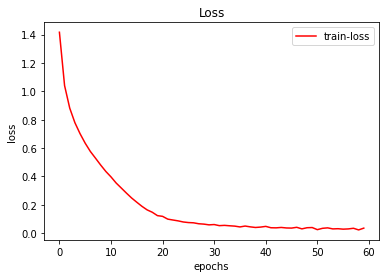

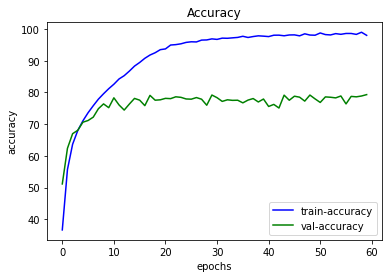

In [ ]:
#GoogLeNet

# Definamos algunos hiper-parámetros
BATCH_SIZE_GLN = 64
LR_GLN = 0.0001
EPOCHS_GLN = 60
REPORTS_EVERY_GLN = 1

net_GLN = GoogLeNet( n_classes = 10) # tu modelo de CNN (para clasificar en 10 clases)
optimizer_GLN = optim.Adam( lr=LR_GLN, params=net_GLN.parameters(), weight_decay=0.0001) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion_GLN = nn.CrossEntropyLoss() # función de pérdida
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1 ) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader_GLN = DataLoader(trainset, batch_size=BATCH_SIZE_GLN,
                          shuffle=True, num_workers=2)
test_loader_GLN = DataLoader(testset, batch_size=2*BATCH_SIZE_GLN,
                         shuffle=False, num_workers=2)

train_loss_GLN, acc_GLN = train_for_classification(net_GLN, train_loader_GLN, 
                                           test_loader_GLN, optimizer_GLN, 
                                           criterion_GLN, #lr_scheduler=scheduler, 
                                           epochs=EPOCHS_GLN, reports_every=REPORTS_EVERY_GLN)

plot_results(train_loss_GLN, acc_GLN)

In [ ]:
# Test GoogLeNet
x_GLN, y_GLN = list(test_loader_GLN)[0]
net_GLN.cpu()
net_GLN.eval()
y_pred_GLN = net_GLN(x_GLN)['logits'].max(dim=1)[1]

# Veamos como se comporta el modelo
print("Correct Test!" if (y_GLN==y_pred_GLN).sum()/len(x_GLN) >= .75 else "Failed Test! [acc]")

Correct Test!


Epoch:1(50000/50000), Loss:1.83670, Train Acc:29.9%, Validating..., Val Acc:31.96%, Avg-Time:152.888s.
Epoch:2(50000/50000), Loss:1.60887, Train Acc:39.6%, Validating..., Val Acc:35.53%, Avg-Time:153.294s.
Epoch:3(50000/50000), Loss:1.47022, Train Acc:45.6%, Validating..., Val Acc:45.91%, Avg-Time:153.522s.
Epoch:4(50000/50000), Loss:1.36326, Train Acc:50.2%, Validating..., Val Acc:54.63%, Avg-Time:153.722s.
Epoch:5(50000/50000), Loss:1.25526, Train Acc:54.4%, Validating..., Val Acc:55.15%, Avg-Time:153.770s.
Epoch:6(50000/50000), Loss:1.16320, Train Acc:58.0%, Validating..., Val Acc:58.33%, Avg-Time:153.826s.
Epoch:7(50000/50000), Loss:1.09957, Train Acc:60.6%, Validating..., Val Acc:62.14%, Avg-Time:153.914s.
Epoch:8(50000/50000), Loss:1.03886, Train Acc:63.1%, Validating..., Val Acc:58.90%, Avg-Time:153.972s.
Epoch:9(50000/50000), Loss:0.99641, Train Acc:64.5%, Validating..., Val Acc:63.87%, Avg-Time:154.005s.
Epoch:10(50000/50000), Loss:0.95678, Train Acc:65.8%, Validating..., Val 

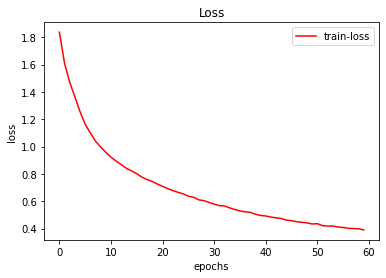

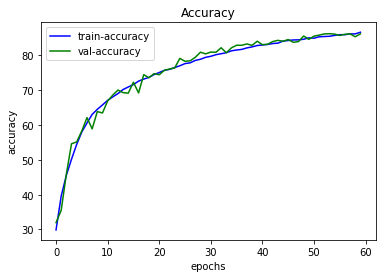

In [9]:
# DenseNet

# Definamos algunos hiper-parámetros
BATCH_SIZE_DN = 64
LR_DN = 0.01
EPOCHS_DN = 60
REPORTS_EVERY_DN = 1

net_DN = DenseNet( n_classes = 10) # tu modelo de CNN (para clasificar en 10 clases)
optimizer_DN = optim.SGD( params=net_DN.parameters(), lr=LR_DN, momentum=0.9, weight_decay=0.0001, nesterov=True) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion_DN = nn.CrossEntropyLoss() # función de pérdida
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1 ) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader_DN = DataLoader(trainset, batch_size=BATCH_SIZE_DN,
                          shuffle=True, num_workers=2)
test_loader_DN = DataLoader(testset, batch_size=2*BATCH_SIZE_DN,
                         shuffle=False, num_workers=2)

train_loss_DN, acc_DN = train_for_classification(net_DN, train_loader_DN, 
                                           test_loader_DN, optimizer_DN, 
                                           criterion_DN, #lr_scheduler=scheduler, 
                                           epochs=EPOCHS_DN, reports_every=REPORTS_EVERY_DN)

plot_results(train_loss_DN, acc_DN)

In [11]:
# Test DenseNet
x_DN, y_DN = list(test_loader_DN)[0]
net_DN.cpu()
net_DN.eval()
y_pred_DN = net_DN(x_DN)['logits'].max(dim=1)[1]

# Veamos como se comporta el modelo
print("Correct Test!" if (y_DN==y_pred_DN).sum()/len(x_DN) >= .75 else "Failed Test! [acc]")

Correct Test!


Estos resultados no son iguales a los que se plantean en el paper de DenseNet (en el paper se plantea que el modelo deberia llegar a 5.92% de error), pues el error que se obtuvo fue de cerca de 14%, esto se puede deber a 2 razones. La primera es que no se ocupo la misma cantidad de epocas en el entrenamiento, en el paper plantea que se usaron 300 epocas, las cuales no fue posible de recrear devbido a diversos problemas que ocurrieron al momento de diseñar la arquitectura, lo que no permitio hacer pruebas para mas epocas, aun asi por el grafico es posible intuir que seguira aumenta la precision tanto en el trainset como en el testset. La otra razon es que para este entrenamiento no se implemento un metodo para poder ir disminuyendo el leraning rate a medida que iba aumentando la cantidad de epocas transcurridas, esto no se hizo debido al poco tiempo que se dispondia para realizar la tarea(debido a los percances con la arquitectura) y tambien porque el paper planteaba reducir a la mitad el LR pasadas las primeras 150 epocas, a lo cual no era posible llegar. Aun asi los resutlados que se obtuvieron son bastante buenos (se cumplio el requisito de la tarea y un poco mas).

## 1e) Opcional: CIFAR100

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para CIFAR100.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=True,
                                         download=True, transform=transform)

testset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=False,
                                        download=True, transform=transform)

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = ...
LR = ...
EPOCHS = ...
REPORTS_EVERY = 1

net = ... # tu modelo de CNN (para clasificar en 100 clases)
optimizer = ... # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = ... # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader, 
                                           test_loader, optimizer, 
                                           criterion, lr_scheduler=scheduler, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

# Parte 2: Subtitulado de Imágenes mediante Recuperación de Textos

## 2a) Codificación de Imágenes y Textos

In [12]:
class ImageEncoding(nn.Module):
  def __init__(self, cnn_model, cnn_out_size, out_size=128, use_last_bn=True):
    super(ImageEncoding, self).__init__()
    self.cnn_model = cnn_model

    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    self.batchNorm1 = nn.BatchNorm1d( cnn_out_size)
    self.layer1 = nn.Linear( cnn_out_size, out_size*2)
    self.batchNorm2 = nn.BatchNorm1d( out_size*2)
    self.layer2 = nn.Linear( out_size*2, out_size)

    self.use_last_bn = use_last_bn
    if use_last_bn:
      self.bn = nn.BatchNorm1d(out_size)

  def forward(self, x):
    x = self.cnn_model(x)['hidden']

    # Compute las capas de su MLP
    x = F.relu(self.batchNorm1(x))
    x = self.layer1(x)

    x = F.relu(self.batchNorm2(x))
    logits = self.layer2(x)

    if self.use_last_bn:
      logits = self.bn(logits)
    # En fc_out debe almacenar el encoding en R^d
    return {'logits':logits}

In [13]:
class TextEncoding(nn.Module):
  def __init__(self, text_embedding_size=4096, out_size=128, use_last_bn=True):
    super(TextEncoding, self).__init__()

    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    self.batchNorm1 = nn.BatchNorm1d( text_embedding_size)
    self.layer1 = nn.Linear( text_embedding_size, out_size*2)
    self.batchNorm2 = nn.BatchNorm1d( out_size*2)
    self.layer2 = nn.Linear( out_size*2, out_size)

    self.use_last_bn = use_last_bn
    if use_last_bn:
      self.bn = nn.BatchNorm1d(out_size)

  def forward(self, x):
    # Compute las capas de su MLP
    x = F.relu(self.batchNorm1(x))
    x = self.layer1(x)

    x = F.relu(self.batchNorm2(x))
    logits = self.layer2(x)

    if self.use_last_bn:
      logits = self.bn(logits)

    # En logits debe almacenar el encoding en R^d
    return {'logits': logits}

In [ ]:
# Test
OUT_SIZE = 200

cnn_net = GoogLeNet(1024)
i_enc = ImageEncoding(cnn_model=cnn_net, cnn_out_size=cnn_out_size_GLN, out_size=OUT_SIZE)
t_enc = TextEncoding(text_embedding_size=4096, out_size=OUT_SIZE)
i_enc.eval()
t_enc.eval()

# Veamos como se comportan tus encoders
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size()==t_enc(torch.randn(9,4096))['logits'].size()) else "Failed Test [size]")
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size(-1)==OUT_SIZE) else "Failed Test [size]")

Correct Test!
Correct Test!


## 2b) Buenas codificaciones y la *Triplet Loss*

In [14]:
class TripletLoss(nn.Module):
  def __init__(self, margin=.2, negative='max'):
    super(TripletLoss, self).__init__()
    self.margin = margin
    self.negative = negative

  def forward(self, anchor, positive):
    # Posiblemente lo más simple es partir calculando la distancia Euclideana
    # entre las imagenes ancla y todos los pares (B x B) de representaciones
    # de textos (hint: usa torch.cdist)
    dists = torch.cdist( anchor,positive)

    # Obtener distancias "positivas" de la diagonal
    p_dist = dists.diag()
    p_dist = p_dist.unsqueeze(1).expand_as(dists)

    # Ahora genera un tensor con todos los costos
    # siguiendo la formula vista en la orientación de la tarea
    cost = (p_dist - dists + self.margin).clamp(min=0).fill_diagonal_(0)

    # Ahora genera un tensor con todos los costos que se deben agregar
    # dependiendo de la forma de encontrar los negativos
    if self.negative == 'max':
      cost = torch.max(cost,dim=1)[0]
    elif self.negative == 'random':
      B = anchor.size()[0]
      # creamos tansor con los pesos para hacer la selección elatoria
      # (una matriz con 1 en todas las posiciones, excepto la diagonal)
      weight = torch.ones_like(cost)-torch.eye(B)
      # seleccionamos aleatoriamente un costo negativo por cada anchor
      ids = torch.multinomial(weight, num_samples=B)
      cost = cost.gather(1, ids)
    elif not self.negative == 'all':
      raise ValueError()
    
    # Retorna el promedio de los costos de todos los triples considerados
    return cost[cost>0].mean()

In [ ]:
# Tests del API del curso para TripletLoss

# Obtengamos algunos parametros para probar tu implementación
for test in [1,2]:
  a, p, m, n  = corrector.get_test_data(homework=4, question="2b", test=test, token=token)

  criterion = TripletLoss(margin=m, negative=n)
  result = criterion(torch.tensor(a), torch.tensor(p)).item()

  # Veamos si todo fue OK :)
  corrector.submit(homework=4, question="2b", test=test, token=token, answer=result, time=0)

Correct Test!
Correct Test!


## 2c) Probando tu implementación en Flickr8k

In [15]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las dos celdas siguientes
# tendrás los datos en train_flickr_tripletset y similar para val y test
##############################################################################

folder_path = './data/flickr8k'
if not os.path.exists(f'{folder_path}/images'):
  print('\n*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...')
  print('****** Descargando las imágenes...\n')
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip -P $folder_path/images
  print('\n********* Extrayendo las imágenes...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -q $folder_path/images/Flickr8k_Dataset.zip -d $folder_path/images
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://hockenmaier.cs.illinois.edu/8k-pictures.html -P $folder_path/annotations

transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

print('Inicializando pytorch Flickr8k dataset')
full_flickr_set = torchvision.datasets.Flickr8k(root=f'{folder_path}/images/Flicker8k_Dataset',
                                                ann_file = f'{folder_path}/annotations/8k-pictures.html',
                                                transform=transform)
print('Creando train, val y test splits...')

train_flickr_set, val_flickr_set, test_flickr_set = [], [], []
for i, item in enumerate(full_flickr_set):
  if i<6000:
    train_flickr_set.append(item)
  elif i<7000:
    val_flickr_set.append(item)
  else:
    test_flickr_set.append(item)


*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...
****** Descargando las imágenes...

--2020-12-16 18:57:19--  https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip
Resolving s06.imfd.cl (s06.imfd.cl)... 192.80.24.186
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115419746 (1.0G) [application/zip]
Saving to: ‘./data/flickr8k/images/Flickr8k_Dataset.zip’

Flickr8k_Dataset.zi  97%[==================> ]   1.01G  6.70MB/s    in 3m 7s   

2020-12-16 19:00:27 (5.52 MB/s) - Connection closed at byte 1082592605. Retrying.

--2020-12-16 19:00:28--  (try: 2)  https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 1115419746 (1.0G), 32827141 (31M) remaining [application/zip]
Saving to: ‘./data/flickr8k/images/Flickr8k_Dataset.zip’

Flic

In [16]:
##############################################################################
# Descarguemos representaciones de los textos de 4096 dimensiones
##############################################################################
if not os.path.exists(f'{folder_path}/flickr_cap_encodings_4096d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/flickr_cap_encodings_4096d.pkl -P $folder_path

with open(f'{folder_path}/flickr_cap_encodings_4096d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs, test_cap_encs = pickle.load(f)

# Creamos un dataset para cada uno de los splits con nuestro ImageCaptionDataset
train_flickr_tripletset = ImageCaptionDataset(train_flickr_set, train_cap_encs)
val_flickr_tripletset = ImageCaptionDataset(val_flickr_set, val_cap_encs)
test_flickr_tripletset = ImageCaptionDataset(test_flickr_set, test_cap_encs)

##############################################################################
# Acá termina el código para preparar los datos
##############################################################################

--2020-12-16 19:02:36--  https://s06.imfd.cl/04/CC6204/tareas/tarea4/flickr_cap_encodings_4096d.pkl
Resolving s06.imfd.cl (s06.imfd.cl)... 192.80.24.186
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628212160 (599M) [application/octet-stream]
Saving to: ‘./data/flickr8k/flickr_cap_encodings_4096d.pkl’

flickr_cap_encoding 100%[===================>] 599.11M  5.20MB/s    in 74s     

2020-12-16 19:03:51 (8.06 MB/s) - ‘./data/flickr8k/flickr_cap_encodings_4096d.pkl’ saved [628212160/628212160]



Epoch:1(6000/6000), Loss:2.45488, Train MRR:0.24 R@10:57.31%, Validating...MRR:0.28 R@10:64.16% Avg-Time:29.995s.
Epoch:2(6000/6000), Loss:1.72609, Train MRR:0.57 R@10:88.25%, Validating...MRR:0.29 R@10:65.04% Avg-Time:30.043s.
Epoch:3(6000/6000), Loss:1.54161, Train MRR:0.72 R@10:94.30%, Validating...MRR:0.30 R@10:64.84% Avg-Time:30.168s.
Epoch:4(6000/6000), Loss:1.35475, Train MRR:0.80 R@10:97.27%, Validating...MRR:0.34 R@10:68.16% Avg-Time:30.307s.
Epoch:5(6000/6000), Loss:1.23366, Train MRR:0.84 R@10:98.62%, Validating...MRR:0.31 R@10:67.97% Avg-Time:30.405s.
Epoch:6(6000/6000), Loss:1.19300, Train MRR:0.87 R@10:98.99%, Validating...MRR:0.30 R@10:67.19% Avg-Time:30.476s.
Epoch:7(6000/6000), Loss:1.09436, Train MRR:0.89 R@10:99.48%, Validating...MRR:0.30 R@10:66.02% Avg-Time:30.515s.
Epoch:8(6000/6000), Loss:nan, Train MRR:0.91 R@10:99.52%, Validating...MRR:0.30 R@10:66.02% Avg-Time:30.567s.
Epoch:9(6000/6000), Loss:1.07139, Train MRR:0.92 R@10:99.55%, Validating...MRR:0.32 R@10:68.

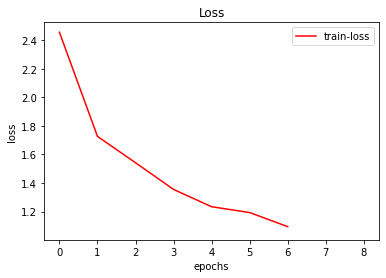

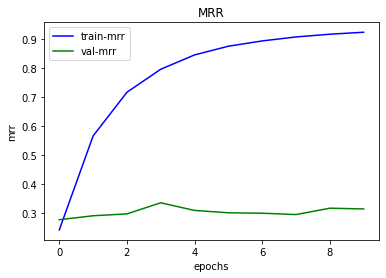

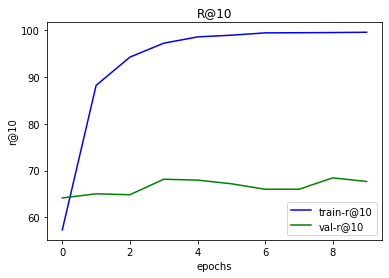

In [18]:
##############################################################################
# Esta es la parte donde tienes que modificar para poder probar tu 
# implementación. 
# En general sólo es necesario que modifiques los lugares con "...", pero 
# eres libre de hacer tus propias implementaciones de todo lo que aparece.
##############################################################################

BATCH_SIZE = 32
LR = 1e-4
EPOCHS = 10
REPORTS_EVERY = 1
CNN_OUT_SIZE = cnn_out_size_DN
EMBEDDING_SIZE = 4096
OUT_SIZE = 512
MARGIN = .2
NEGATIVE = 'max'

cnn_net = net_DN
img_net = ImageEncoding(cnn_model=cnn_net, cnn_out_size=CNN_OUT_SIZE, 
                        out_size=OUT_SIZE) 

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': img_net.parameters()},  # lista de parametros de img_net
                        {'params': text_net.parameters()}],  # lista de parametros de text_net
                       lr=LR)
criterion = TripletLoss(margin=MARGIN, negative=NEGATIVE)
#scheduler =   (opcional) optim.lr_scheduler proporciona varios métodos 
                # para ajustar el lr según el número de épocas

train_triplets_loader = DataLoader(train_flickr_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_flickr_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net, 
                                              train_triplets_loader, 
                                              val_triplets_loader, optimizer, 
                                              criterion, epochs=EPOCHS, reports_every=REPORTS_EVERY, norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')

Correct Test!


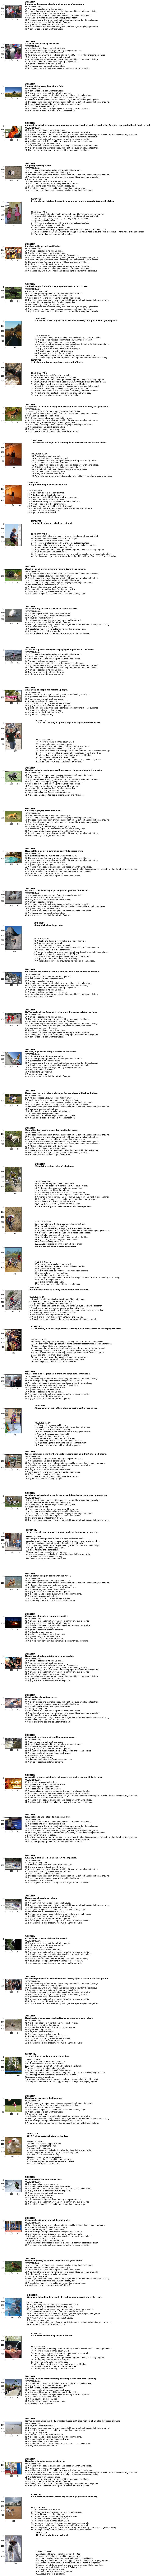

In [19]:
# Test
from PIL import Image
n_samples = 64

# Tomemos n_samples ejemplos del conjunto de test
samples = torch.stack([test_flickr_tripletset[i][0] for i in range(n_samples)]).cuda()
refs = torch.stack([torch.from_numpy(test_flickr_tripletset[i][1]) for i in range(n_samples)]).cuda()
test_caps = [caps[0] for _, caps in test_flickr_set][:n_samples]

# Computamos las representaciones en el espacio compartido
samples_enc = img_net(samples)['logits']
refs_enc = text_net(refs)['logits']

# Calculemos las distancias a cada uno de los textos de test y rankeamos
dists = torch.cdist(samples_enc.unsqueeze(0), refs_enc.unsqueeze(0), p=2).squeeze(0)
ranks = torch.argsort(dists, dim=1)[:,:10]
r10 = len([i for i in range(len(ranks)) if len(torch.where(ranks[i,:] == i)[0])]) / len(ranks)

# Veamos como se comporta el modelo
print("Correct Test!" if r10 >= .25 else "Failed Test! [R@10]")

# Mostremos las 10 descripciones más cercanas
fig, axs = plt.subplots(nrows=n_samples, figsize=(2,n_samples*5))
for i in range(n_samples):
  axs[i].imshow(Image.open(full_flickr_set.ids[7000+i]))
  axs[i].text(600,0,"EXPECTED:\n{}: {}".format(i, test_caps[i]), fontsize=12, fontweight='bold')
  axs[i].text(600,750,"PREDICTED RANK:\n{}".format('\n'.join([f'{j}: {test_caps[j]}' for j in ranks[i]])), fontsize=12)

## 2d) Opcional: COCO Captions

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para COCO Captions.
##############################################################################

folder_path = './data/coco-caps'
if not os.path.exists(f'{folder_path}/images/train2014'):
  print('\n*** Descargando y extrayendo COCO Captions, siéntese y relájese unos 20 mins...')
  print('****** Descargando training set...\n')
  !wget http://images.cocodataset.org/zips/train2014.zip -P $folder_path/images
  print('\n********* Extrayendo training set...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -q $folder_path/images/train2014.zip -d $folder_path/images && rm $folder_path/images/train2014.zip
  print('\n*** Descargando y extrayendo validation set...\n')
  !wget http://images.cocodataset.org/zips/val2014.zip -P $folder_path/images && unzip -q $folder_path/images/val2014.zip -d $folder_path/images && rm $folder_path/images/val2014.zip
  # !wget http://images.cocodataset.org/zips/test2014.zip -P $folder_path/images && unzip -q $folder_path/images/test2014.zip -d $folder_path/images && rm $folder_path/images/test2014.zip
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P $folder_path && unzip -q $folder_path/annotations_trainval2014.zip -d $folder_path && rm $folder_path/images/annotations_trainval2014.zip

transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/train2014',
                                                   annFile = f'{folder_path}/annotations/captions_train2014.json',
                                                   transform=transform)

val_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/val2014',
                                                 annFile = f'{folder_path}/annotations/captions_val2014.json',
                                                 transform=transform)

# test_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/test2014',
#                                                   transform=transform)

In [ ]:
if not os.path.exists(f'{folder_path}/cap_encodings_512d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/cap_encodings_512d.pkl -P $folder_path

with open(f'{folder_path}/cap_encodings_512d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs = pickle.load(f)

train_coco_tripletset = ImageCaptionDataset(train_coco_set, train_cap_encs)
val_coco_tripletset = ImageCaptionDataset(val_coco_set, val_cap_encs)

In [ ]:
BATCH_SIZE = 256
LR = 1e-4
EPOCHS = 10
REPORTS_EVERY = 1
CNN_PREV_SIZE = 1024
EMBEDDING_SIZE = 512
OUT_SIZE = 512
MARGIN = .2

cnn_net = ...
img_net = ImageEncoding(cnn_model=..., cnn_out_size=CNN_PREV_SIZE, 
                        out_size=OUT_SIZE) 

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': ...},
                        {'params': ...}], 
                       lr=LR)
criterion = TripletLoss(margin=...)

train_triplets_loader = DataLoader(train_coco_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_coco_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net, 
                                                     train_triplets_loader, 
                                                     val_triplets_loader, 
                                                     optimizer, criterion, 
                                                     EPOCHS, REPORTS_EVERY, 
                                                     norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')